# Cleaning

In [1]:
# Importing necessary modules
import seaborn as sns
import pyspark.sql.functions as F
import pandas as pd
import matplotlib.pyplot as plt
from operator import add
from functools import reduce
import numpy as np
import re
import os
from pyspark.sql.types import StructField, StructType, StringType, LongType, FloatType
from pyspark.sql.functions import *
import random
from pyspark.ml.feature import StandardScaler, VectorAssembler, Imputer, StringIndexer
from pyspark.ml.functions import vector_to_array
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import RFormula
import time

# Setting up visualization
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
cols_to_keep = [
    "Voters_Gender", # cat
    "Voters_Age", # num
    "Voters_BirthDate", # ignore
    "Residence_Families_HHCount", # num
    "Residence_HHGender_Description", # cat
    "Mailing_Families_HHCount", # num
    "Mailing_HHGender_Description", # cat

#   !! voter party affiliation
    "Parties_Description", 
    
    # cat
    "CommercialData_PropertyType",
    "AddressDistricts_Change_Changed_CD",
    "AddressDistricts_Change_Changed_SD",
    "AddressDistricts_Change_Changed_HD",
    "AddressDistricts_Change_Changed_County",
    
    "Residence_Addresses_Density", # num
    
    # cat
    "CommercialData_EstimatedHHIncome",
    "CommercialData_ISPSA",
    # num
    "CommercialData_AreaMedianEducationYears",
    "CommercialData_AreaMedianHousingValue",
#    "CommercialData_MosaicZ4Global",
    # cat
     "CommercialData_AreaPcntHHMarriedCoupleNoChild",  
     "CommercialData_AreaPcntHHMarriedCoupleWithChild",
     "CommercialData_AreaPcntHHSpanishSpeaking",
     "CommercialData_AreaPcntHHWithChildren",
     "CommercialData_StateIncomeDecile",
#    "Ethnic_Description",
    "EthnicGroups_EthnicGroup1Desc",
    "CommercialData_DwellingType",
    "CommercialData_PresenceOfChildrenCode",
#    "CommercialData_PresenceOfPremCredCrdInHome", ## too many missing
    "CommercialData_DonatesToCharityInHome",
    "CommercialData_DwellingUnitSize",
    "CommercialData_ComputerOwnerInHome",
    "CommercialData_DonatesEnvironmentCauseInHome",
    "CommercialData_Education",
    
#   Don't include because of lookahead bias  
#     "Voters_VotingPerformanceEvenYearGeneral",
#     "Voters_VotingPerformanceEvenYearPrimary",
#     "Voters_VotingPerformanceEvenYearGeneralAndPrimary",
#     "Voters_VotingPerformanceMinorElection",
    
#   Other control variables that expect to be highly associated with outcome:
#     "ElectionReturns_P08CountyTurnoutAllRegisteredVoters",
#     "ElectionReturns_P08CountyTurnoutDemocrats",
#     "ElectionReturns_P08CountyTurnoutRepublicans",
    "General_2000",
    "General_2004",
    "PresidentialPrimary_2000",
    "PresidentialPrimary_2004",
        
#   Outcome variable (indiana law happens in 2005, approved by SCOTUS before presidential election in 2008)
    "General_2008"
]

In [3]:
pct = [
    "CommercialData_AreaPcntHHMarriedCoupleNoChild",  
     "CommercialData_AreaPcntHHMarriedCoupleWithChild",
     "CommercialData_AreaPcntHHSpanishSpeaking",
     "CommercialData_AreaPcntHHWithChildren"
]
    
numeric_cols = [
    'Voters_Age',
    'Residence_Families_HHCount',
    'Mailing_Families_HHCount',
    'Residence_Addresses_Density',
    "CommercialData_AreaMedianEducationYears",
    "CommercialData_AreaMedianHousingValue"
] + pct

trinary_cols = [
    'CommercialData_DonatesToCharityInHome',
    'CommercialData_ComputerOwnerInHome',
    'CommercialData_DonatesEnvironmentCauseInHome'
]

dont_touch_cols = [
    "General_2008", 
    "Voters_BirthDate", 
    "General_2000",
    "General_2004",
    "PresidentialPrimary_2000",
    "PresidentialPrimary_2004"
]

cols_excluded_from_regression = [
    'STATE',
    'General_2008'
]

categorical_cols = [c for c in cols_to_keep if c not in (dont_touch_cols+numeric_cols+cols_excluded_from_regression)]
#other_cols = [c for c in other_cols if c not in (numeric_cols + trinary_cols)]

In [4]:
# These are the states that do not have strict voter ID laws:
#  'VM2Uniform--CA--2021-05-02',	VM2Uniform--CA--2021-05-02	CA	x	California
#  'VM2Uniform--IL--2021-03-05',	VM2Uniform--IL--2021-03-05	IL	x	Illinois
#  'VM2Uniform--MA--2021-01-19',	VM2Uniform--MA--2021-01-19	MA	x	Massachusetts
#  'VM2Uniform--MD--2021-02-15',	VM2Uniform--MD--2021-02-15	MD	x	Maryland
#  'VM2Uniform--ME--2021-05-28',	VM2Uniform--ME--2021-05-28	ME	x	Maine
#  'VM2Uniform--MN--2021-02-14',	VM2Uniform--MN--2021-02-14	MN	x	Minnesota
#  'VM2Uniform--NC--2021-05-18',	VM2Uniform--NC--2021-05-18	NC	x	North Carolina
#  'VM2Uniform--NE--2021-01-20',	VM2Uniform--NE--2021-01-20	NE	x	Nebraska
#  'VM2Uniform--NJ--2021-03-11',	VM2Uniform--NJ--2021-03-11	NJ	x	New Jersey
#  'VM2Uniform--NM--2021-02-25',	VM2Uniform--NM--2021-02-25	NM	x	New Mexico
#  'VM2Uniform--NV--2021-06-13',	VM2Uniform--NV--2021-06-13	NV	x	Nevada
#  'VM2Uniform--NY--2021-03-15',	VM2Uniform--NY--2021-03-15	NY	x	New York
#  'VM2Uniform--OR--2021-02-05',	VM2Uniform--OR--2021-02-05	OR	x	Oregon
#  'VM2Uniform--PA--2021-05-20',	VM2Uniform--PA--2021-05-20	PA	x	Pennsylvania
#  'VM2Uniform--VT--2021-05-28',	VM2Uniform--VT--2021-05-28	VT	x	Vermont

# For each of these states, I want to pull enough samples to get a total sample of 1/2 M; can increase later

# grab files
states =  [
# For now, just exclude New York and Califonria, because the parquet files take too long to read
'VM2Uniform--VT--2021-05-28', 
'VM2Uniform--IL--2021-03-05',
'VM2Uniform--MA--2021-01-19',
'VM2Uniform--MD--2021-02-15',
'VM2Uniform--ME--2021-05-28',
'VM2Uniform--MN--2021-02-14',
'VM2Uniform--NC--2021-05-18',
'VM2Uniform--NE--2021-01-20',
'VM2Uniform--NJ--2021-03-11',
'VM2Uniform--NM--2021-02-25',
'VM2Uniform--NV--2021-06-13',
'VM2Uniform--OR--2021-02-05',
'VM2Uniform--PA--2021-05-20',
'VM2Uniform--CA--2021-05-02',
'VM2Uniform--NY--2021-03-15',
]

# bucket file path for all state parquet files
gcs_path = 'gs://pstat135-voter-file/VM2Uniform'

# create list of state abbreviations
pattern = re.compile(r"(?<=--)[A-Z]{2}")
state_abvs = re.findall(pattern, ''.join(states))

# do first iteration
print('VM2Uniform--VT--2021-05-28')

# num_per_state = 500

df_ref = spark.read.parquet("/".join([gcs_path, 'VM2Uniform--VT--2021-05-28']))
df_ref = df_ref.select(cols_to_keep)

numrows = {'VM2Uniform--VT--2021-05-28': df_ref.count()}

print("%d" % (numrows['VM2Uniform--VT--2021-05-28']))
    
# percentage_sample = num_per_state / numrows['VM2Uniform--VT--2021-05-28']
    
# df_ref = df_ref.sample(True, percentage_sample, seed = 19480384)
df_ref = df_ref.withColumn('STATE', F.lit(state_abvs[0]))
 
next_states = states[1:]

# do the rest of the iterations
for i, one_state in enumerate(next_states):

    print("%s: " % (one_state), end="")
    
    # read dataframe for one_state
    tmp_ref = spark.read.parquet("/".join([gcs_path, one_state]))
    tmp_ref = tmp_ref.select(cols_to_keep)
    numrows[one_state] = tmp_ref.count()
    print("%d" % (numrows[one_state]))
    
#     percentage_sample = num_per_state / numrows[one_state]
    
#     tmp_ref = tmp_ref.sample(True, percentage_sample, seed = 19480384)
    tmp_ref = tmp_ref.withColumn('STATE', F.lit(state_abvs[i+1]))
    
    df_ref = df_ref.union(tmp_ref)      

df_ref.printSchema()
df_ref.count()

VM2Uniform--VT--2021-05-28


463261
VM2Uniform--IL--2021-03-05: 

8336875
VM2Uniform--MA--2021-01-19: 

4572639
VM2Uniform--MD--2021-02-15: 

4110570
VM2Uniform--ME--2021-05-28: 

1040452
VM2Uniform--MN--2021-02-14: 

3563623
VM2Uniform--NC--2021-05-18: 

6616158
VM2Uniform--NE--2021-01-20: 

1201308
VM2Uniform--NJ--2021-03-11: 

6109844
VM2Uniform--NM--2021-02-25: 

1205712
VM2Uniform--NV--2021-06-13: 

1866442
VM2Uniform--OR--2021-02-05: 

3166785
VM2Uniform--PA--2021-05-20: 

8359764
VM2Uniform--CA--2021-05-02: 

21779518
VM2Uniform--NY--2021-03-15: 

12570650
root
 |-- Voters_Gender: string (nullable = true)
 |-- Voters_Age: string (nullable = true)
 |-- Voters_BirthDate: string (nullable = true)
 |-- Residence_Families_HHCount: string (nullable = true)
 |-- Residence_HHGender_Description: string (nullable = true)
 |-- Mailing_Families_HHCount: string (nullable = true)
 |-- Mailing_HHGender_Description: string (nullable = true)
 |-- Parties_Description: string (nullable = true)
 |-- CommercialData_PropertyType: string (nullable = true)
 |-- AddressDistricts_Change_Changed_CD: string (nullable = true)
 |-- AddressDistricts_Change_Changed_SD: string (nullable = true)
 |-- AddressDistricts_Change_Changed_HD: string (nullable = true)
 |-- AddressDistricts_Change_Changed_County: string (nullable = true)
 |-- Residence_Addresses_Density: string (nullable = true)
 |-- CommercialData_EstimatedHHIncome: string (nullable = true)
 |-- CommercialData_ISPSA: string (nullable = true)
 |-- CommercialData_AreaMedianEducationYears: string (nullable

84963601

### FUNCTIONS TO CLEAN DATASET

In [5]:
def clean_voter_participation(input_df: DataFrame) -> DataFrame:

    yrs_add = 18
    months_add = 18*12

    # date of national 
    target_month_day_presidential = "11-03"

    # date of presidential primary (ideally we should do this state by state, but this is the date for Indiana's)
    target_month_day_primary = "05-03" 

    input_df = input_df.withColumn("DATE_18", add_months(to_date(col("Voters_BirthDate"),"MM/dd/yyyy"), months_add))
    input_df.select(["Voters_BirthDate", "DATE_18"]).show(10)
    input_df = input_df.dropna(subset = "Voters_BirthDate")
    input_df = input_df.withColumn("YEAR_18", year("DATE_18"))
    input_df = input_df.withColumn("comparator_date_presidential", to_date(concat(col("YEAR_18"), lit("-"), lit(target_month_day_presidential))))
    input_df = input_df.withColumn("comparator_date_primary", to_date(concat(col("YEAR_18"), lit("-"), lit(target_month_day_primary))))

    for election in ["PRESIDENTIAL", "PRIMARY"]:
        input_df = input_df.withColumn(f"YEAR_ELIGIBLE_TO_VOTE_{election}", \
                                    when(col("DATE_18")<=col(f"comparator_date_{election.lower()}"), col("YEAR_18")) \
                                   .otherwise(col("YEAR_18") + 1) \
                                  )

    # check no missing vals:
    input_df.where(col("YEAR_18").isNull()).select("YEAR_18").show(10)

    # get rid of rows where the voter was not old enough to vote in the 2008 general election
    input_df = input_df.filter(col("YEAR_ELIGIBLE_TO_VOTE_PRESIDENTIAL")<=2008).fillna("N", subset = ["General_2008"])

    # for the 2000 and 2004 general elections, replace with "N" IF the person was old enough to vote at the time

    for election in ["2000", "2004"]:
        input_df = input_df.withColumn(f"General_{election}", \
                                   when((col("YEAR_ELIGIBLE_TO_VOTE_PRESIDENTIAL")<= int(election)) & \
                                        (col(f"General_{election}").isNull()), "N") \
                                   .otherwise(col(f"General_{election}")) \
                                  )

        input_df = input_df.withColumn(f"PresidentialPrimary_{election}", \
                                   when((col("YEAR_ELIGIBLE_TO_VOTE_PRIMARY")<= int(election)) & \
                                        (col(f"PresidentialPrimary_{election}").isNull()), "N") \
                                   .otherwise(col(f"PresidentialPrimary_{election}")) \
                                  )

    # make the general voting for 2008 a numeric variable; since we've deleted
    # everyone who was not eligible to vote, this can be directly calculated with a 1-0.
    input_df = input_df.withColumn("Voted_General_2008", when(input_df.General_2008 == "Y",1).otherwise(0))
    input_df = input_df.withColumn("General_2008", F.col("Voted_General_2008"))
    
    elec_cols = ["General_2000", "General_2004", "PresidentialPrimary_2000", "PresidentialPrimary_2004"]
    input_df = input_df.fillna("Unknown", subset=elec_cols)
    
    to_drop = [
        'Voters_BirthDate', # removed this, but KEPT the YEAR that the voter turned 18.
        'DATE_18',
        'YEAR_18',
        'comparator_date_presidential',
        'comparator_date_primary',
        'YEAR_ELIGIBLE_TO_VOTE_PRESIDENTIAL',
        'YEAR_ELIGIBLE_TO_VOTE_PRIMARY',
        'Voted_General_2008'
    ]
    input_df = input_df.drop(*to_drop)
    
    return input_df

In [6]:
def clean_numeric_categorical(input_df: DataFrame) -> DataFrame:
    
    # remove special symbols ($, %) from relevant columns
    input_df = input_df.withColumn(
        "CommercialData_AreaMedianHousingValue",
        F.expr("substring(CommercialData_AreaMedianHousingValue, 2, length(CommercialData_AreaMedianHousingValue))"))

    for c in pct:
        input_df = input_df.withColumn(
            c,
            F.expr(f"substring({c}, 1, length({c})-1)")
        )
    input_df.select(["CommercialData_AreaMedianHousingValue"]+pct).show()


    for c in numeric_cols:
        input_df = input_df.withColumn(c, F.col(c).cast("float").alias(c))
#     input_df = input_df.fillna("U", subset= trinary_cols)
#     input_df = input_df.fillna("Missing", subset = other_cols)
#   input_df = input_df.fillna("N", subset = binary_cols)
    
    return input_df

In [7]:
def impute_numeric_values_function(input_df: DataFrame) -> DataFrame:

    # Create copy of working df
    input_df = input_df.alias('input_df')
    
    # Impute the missing values in the numerical columns with the mean -- minimize change to z-scores of given data
    imputer = Imputer(
        inputCols=numeric_cols, 
        outputCols=numeric_cols
    )

    input_df = imputer.fit(input_df).transform(input_df)
    
    return input_df

In [8]:
def impute_categorical_values_function(input_df: DataFrame) -> DataFrame:

    # Create copy of working df
    input_df = input_df.alias('input_df')
    
    input_df = input_df.withColumn("CommercialData_ISPSA", F.col("CommercialData_ISPSA").cast('string'))
    input_df = input_df.withColumn("CommercialData_StateIncomeDecile",
                                   F.col("CommercialData_StateIncomeDecile").cast('string'))
    
    input_df = input_df.fillna("U", subset= trinary_cols)
    input_df = input_df.fillna("Unknown", subset = categorical_cols)
    
    return input_df

In [9]:
indi = spark.read.parquet("gs://voter-project-235-25/VM2Uniform--IN--2021-01-15_parq")
indi = indi.sample(True, 0.1, seed = 19480384)
indi = indi.select(cols_to_keep)
indi = indi.withColumn("STATE", lit("IN"))

In [10]:
indi = clean_voter_participation(indi)
indi = clean_numeric_categorical(indi)
indi = impute_numeric_values_function(indi)
indi = impute_categorical_values_function(indi)
indi.printSchema()

+----------------+----------+
|Voters_BirthDate|   DATE_18|
+----------------+----------+
|      05/03/1996|2014-05-03|
|      05/03/1996|2014-05-03|
|      12/04/1959|1977-12-04|
|      11/11/1964|1982-11-11|
|      05/21/1925|1943-05-21|
|      07/22/1998|2016-07-22|
|      03/31/1966|1984-03-31|
|      12/10/1983|2001-12-10|
|      01/05/1977|1995-01-05|
|      05/18/1993|2011-05-18|
+----------------+----------+
only showing top 10 rows



+-------+
|YEAR_18|
+-------+
+-------+

+-------------------------------------+---------------------------------------------+-----------------------------------------------+----------------------------------------+-------------------------------------+
|CommercialData_AreaMedianHousingValue|CommercialData_AreaPcntHHMarriedCoupleNoChild|CommercialData_AreaPcntHHMarriedCoupleWithChild|CommercialData_AreaPcntHHSpanishSpeaking|CommercialData_AreaPcntHHWithChildren|
+-------------------------------------+---------------------------------------------+-----------------------------------------------+----------------------------------------+-------------------------------------+
|                                 null|                                         null|                                           null|                                    null|                                 null|
|                               172582|                                           41|                      

root
 |-- Voters_Gender: string (nullable = false)
 |-- Voters_Age: float (nullable = true)
 |-- Residence_Families_HHCount: float (nullable = true)
 |-- Residence_HHGender_Description: string (nullable = false)
 |-- Mailing_Families_HHCount: float (nullable = true)
 |-- Mailing_HHGender_Description: string (nullable = false)
 |-- Parties_Description: string (nullable = false)
 |-- CommercialData_PropertyType: string (nullable = false)
 |-- AddressDistricts_Change_Changed_CD: string (nullable = false)
 |-- AddressDistricts_Change_Changed_SD: string (nullable = false)
 |-- AddressDistricts_Change_Changed_HD: string (nullable = false)
 |-- AddressDistricts_Change_Changed_County: string (nullable = false)
 |-- Residence_Addresses_Density: float (nullable = true)
 |-- CommercialData_EstimatedHHIncome: string (nullable = false)
 |-- CommercialData_ISPSA: string (nullable = false)
 |-- CommercialData_AreaMedianEducationYears: float (nullable = true)
 |-- CommercialData_AreaMedianHousingValue

In [ ]:
df_ref = clean_voter_participation(df_ref)
df_ref = clean_numeric_categorical(df_ref)
df_ref = impute_numeric_values_function(df_ref)
df_ref = impute_categorical_values_function(df_ref)
df_ref.printSchema()

In [ ]:
# do the same process for Indiana:
indi = spark.read.parquet("gs://voter-project-235-25/VM2Uniform--IN--2021-01-15_parq")
indi = indi.sample(True, 0.1, seed = 19480384)
indi = indi.select(cols_to_keep)
indi = indi.withColumn("STATE", lit("IN"))

indi = clean_numeric_categorical(indi)
indi = impute_values_function(indi)
indi = clean_voter_participation(indi)
indi.printSchema()

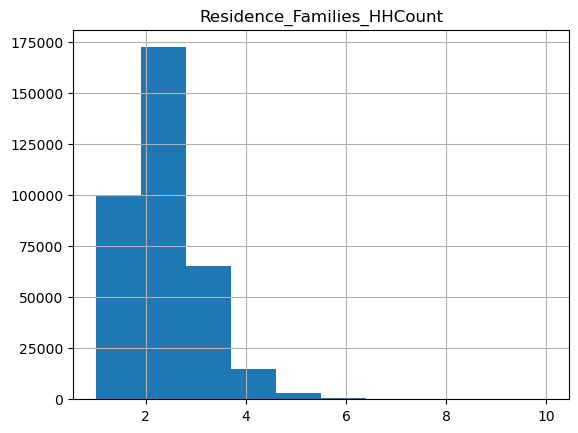

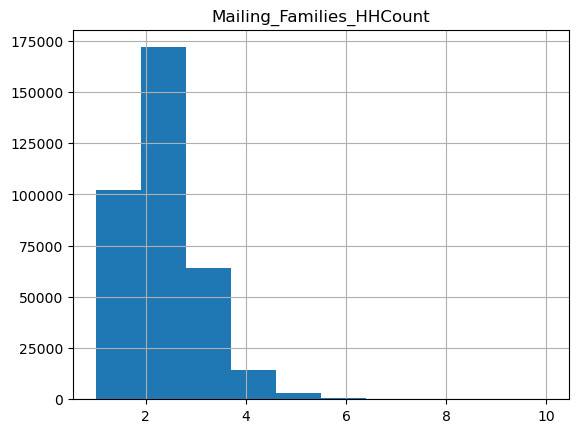

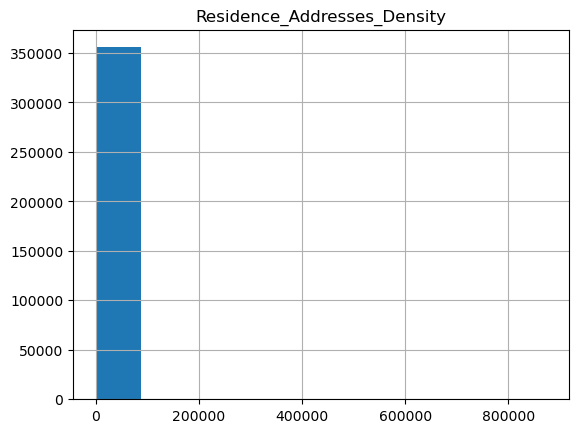

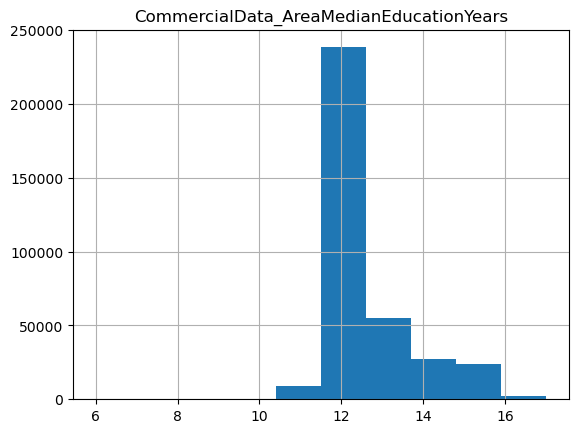

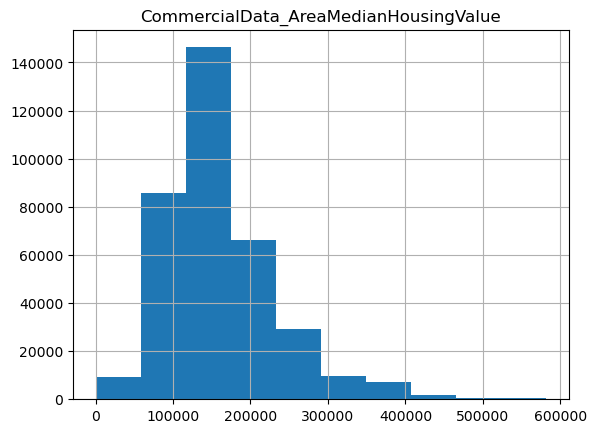

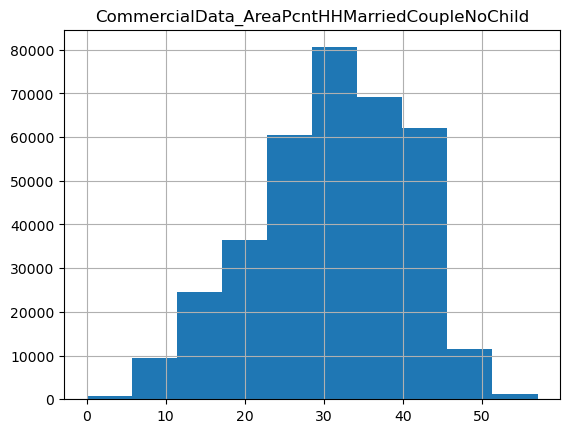

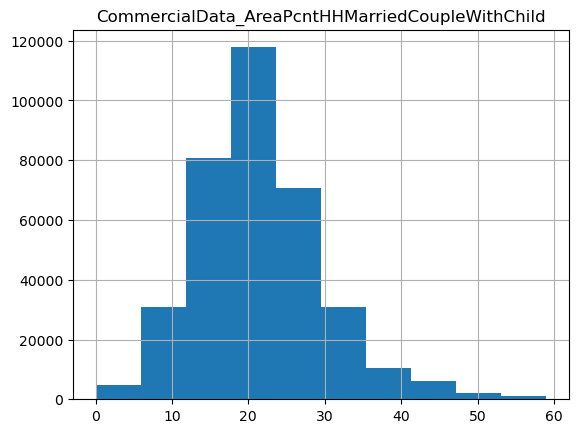

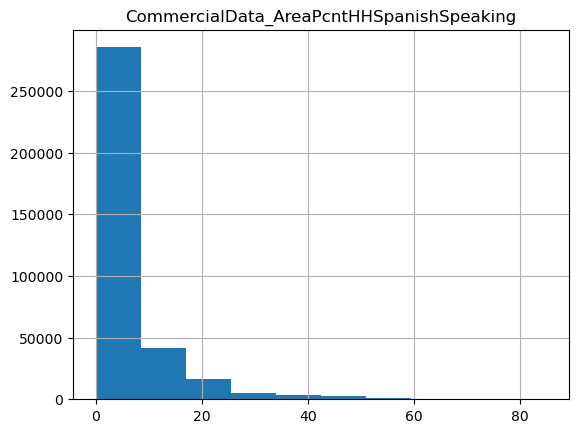

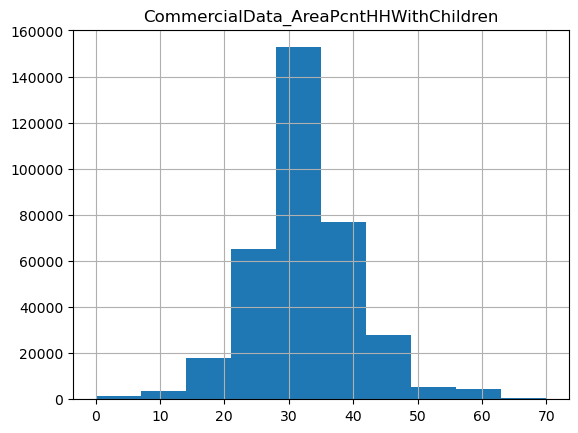

In [27]:
for c in numeric_cols:
    indi.select(c).toPandas().hist()

In [28]:
# GET THE UNIQUE VALUES OF EACH COLUMN
for i in categorical_cols:
    print(indi.select(i).distinct().collect())
    print(i)

[Row(Voters_Gender='F'), Row(Voters_Gender='M'), Row(Voters_Gender='Missing')]
Voters_Gender


[Row(Voters_Age=31), Row(Voters_Age=85), Row(Voters_Age=65), Row(Voters_Age=53), Row(Voters_Age=78), Row(Voters_Age=34), Row(Voters_Age=81), Row(Voters_Age=76), Row(Voters_Age=44), Row(Voters_Age=91), Row(Voters_Age=93), Row(Voters_Age=47), Row(Voters_Age=52), Row(Voters_Age=86), Row(Voters_Age=40), Row(Voters_Age=94), Row(Voters_Age=57), Row(Voters_Age=54), Row(Voters_Age=96), Row(Voters_Age=48), Row(Voters_Age=92), Row(Voters_Age=64), Row(Voters_Age=41), Row(Voters_Age=43), Row(Voters_Age=37), Row(Voters_Age=61), Row(Voters_Age=88), Row(Voters_Age=72), Row(Voters_Age=35), Row(Voters_Age=55), Row(Voters_Age=59), Row(Voters_Age=100), Row(Voters_Age=39), Row(Voters_Age=49), Row(Voters_Age=84), Row(Voters_Age=87), Row(Voters_Age=51), Row(Voters_Age=69), Row(Voters_Age=97), Row(Voters_Age=63), Row(Voters_Age=77), Row(Voters_Age=50), Row(Voters_Age=45), Row(Voters_Age=38), Row(Voters_Age=82), Row(Voters_Age=80), Row(Voters_Age=73), Row(Voters_Age=70), Row(Voters_Age=62), Row(Voters_Age=95)

[Row(Residence_HHGender_Description='Cannot Determine'), Row(Residence_HHGender_Description='Mixed Gender Household'), Row(Residence_HHGender_Description='Female Only Household'), Row(Residence_HHGender_Description='Male Only Household')]
Residence_HHGender_Description


[Row(Mailing_HHGender_Description='Cannot Determine'), Row(Mailing_HHGender_Description='Mixed Gender Household'), Row(Mailing_HHGender_Description='Female Only Household'), Row(Mailing_HHGender_Description='Male Only Household')]
Mailing_HHGender_Description


[Row(Parties_Description='Republican'), Row(Parties_Description='Unknown'), Row(Parties_Description='Other'), Row(Parties_Description='Democratic'), Row(Parties_Description='Non-Partisan')]
Parties_Description


[Row(CommercialData_PropertyType='Apartment'), Row(CommercialData_PropertyType='Mobil Home'), Row(CommercialData_PropertyType='Residential'), Row(CommercialData_PropertyType='Unknown'), Row(CommercialData_PropertyType='Condominium'), Row(CommercialData_PropertyType='Missing'), Row(CommercialData_PropertyType='Triplex'), Row(CommercialData_PropertyType='Duplex')]
CommercialData_PropertyType


[Row(AddressDistricts_Change_Changed_CD='Between 6 Months and 1 Year Ago'), Row(AddressDistricts_Change_Changed_CD='Has Not Changed Within Last 2 Years'), Row(AddressDistricts_Change_Changed_CD='Between 1 and 2 Years Ago'), Row(AddressDistricts_Change_Changed_CD='Within Last 6 Months')]
AddressDistricts_Change_Changed_CD


[Row(AddressDistricts_Change_Changed_SD='Between 6 Months and 1 Year Ago'), Row(AddressDistricts_Change_Changed_SD='Has Not Changed Within Last 2 Years'), Row(AddressDistricts_Change_Changed_SD='Between 1 and 2 Years Ago'), Row(AddressDistricts_Change_Changed_SD='Within Last 6 Months')]
AddressDistricts_Change_Changed_SD


[Row(AddressDistricts_Change_Changed_HD='Between 6 Months and 1 Year Ago'), Row(AddressDistricts_Change_Changed_HD='Has Not Changed Within Last 2 Years'), Row(AddressDistricts_Change_Changed_HD='Between 1 and 2 Years Ago'), Row(AddressDistricts_Change_Changed_HD='Within Last 6 Months')]
AddressDistricts_Change_Changed_HD


[Row(AddressDistricts_Change_Changed_County='Between 6 Months and 1 Year Ago'), Row(AddressDistricts_Change_Changed_County='Has Not Changed Within Last 2 Years'), Row(AddressDistricts_Change_Changed_County='Between 1 and 2 Years Ago'), Row(AddressDistricts_Change_Changed_County='Within Last 6 Months')]
AddressDistricts_Change_Changed_County


[Row(CommercialData_EstimatedHHIncome='$175000-199999'), Row(CommercialData_EstimatedHHIncome='$250000+'), Row(CommercialData_EstimatedHHIncome='$1000-14999'), Row(CommercialData_EstimatedHHIncome='$100000-124999'), Row(CommercialData_EstimatedHHIncome='$75000-99999'), Row(CommercialData_EstimatedHHIncome='$125000-149999'), Row(CommercialData_EstimatedHHIncome='$25000-34999'), Row(CommercialData_EstimatedHHIncome='$200000-249999'), Row(CommercialData_EstimatedHHIncome='$50000-74999'), Row(CommercialData_EstimatedHHIncome='$150000-174999'), Row(CommercialData_EstimatedHHIncome='Missing'), Row(CommercialData_EstimatedHHIncome='$35000-49999'), Row(CommercialData_EstimatedHHIncome='$15000-24999')]
CommercialData_EstimatedHHIncome


[Row(CommercialData_ISPSA=None), Row(CommercialData_ISPSA=1), Row(CommercialData_ISPSA=6), Row(CommercialData_ISPSA=3), Row(CommercialData_ISPSA=5), Row(CommercialData_ISPSA=9), Row(CommercialData_ISPSA=4), Row(CommercialData_ISPSA=8), Row(CommercialData_ISPSA=7), Row(CommercialData_ISPSA=2), Row(CommercialData_ISPSA=0)]
CommercialData_ISPSA


[Row(CommercialData_StateIncomeDecile=None), Row(CommercialData_StateIncomeDecile=1), Row(CommercialData_StateIncomeDecile=6), Row(CommercialData_StateIncomeDecile=3), Row(CommercialData_StateIncomeDecile=5), Row(CommercialData_StateIncomeDecile=9), Row(CommercialData_StateIncomeDecile=4), Row(CommercialData_StateIncomeDecile=8), Row(CommercialData_StateIncomeDecile=7), Row(CommercialData_StateIncomeDecile=2), Row(CommercialData_StateIncomeDecile=0)]
CommercialData_StateIncomeDecile


[Row(EthnicGroups_EthnicGroup1Desc='East and South Asian'), Row(EthnicGroups_EthnicGroup1Desc='European'), Row(EthnicGroups_EthnicGroup1Desc='Other'), Row(EthnicGroups_EthnicGroup1Desc='Likely African-American'), Row(EthnicGroups_EthnicGroup1Desc='Missing'), Row(EthnicGroups_EthnicGroup1Desc='Hispanic and Portuguese')]
EthnicGroups_EthnicGroup1Desc


[Row(CommercialData_DwellingType='Multi-Family Dwelling'), Row(CommercialData_DwellingType='Missing'), Row(CommercialData_DwellingType='Single Family Dwelling Unit')]
CommercialData_DwellingType


[Row(CommercialData_PresenceOfChildrenCode='Modeled Likely to have a child'), Row(CommercialData_PresenceOfChildrenCode='Not Likely to have a child'), Row(CommercialData_PresenceOfChildrenCode='Modeled Not as Likely to have a child'), Row(CommercialData_PresenceOfChildrenCode='Known Data'), Row(CommercialData_PresenceOfChildrenCode='Missing')]
CommercialData_PresenceOfChildrenCode


[Row(CommercialData_DonatesToCharityInHome='Y'), Row(CommercialData_DonatesToCharityInHome='U')]
CommercialData_DonatesToCharityInHome


[Row(CommercialData_DwellingUnitSize='5-9'), Row(CommercialData_DwellingUnitSize='2-Duplex'), Row(CommercialData_DwellingUnitSize='50-100'), Row(CommercialData_DwellingUnitSize='1-Single Family Dwelling'), Row(CommercialData_DwellingUnitSize='10-19'), Row(CommercialData_DwellingUnitSize='Missing'), Row(CommercialData_DwellingUnitSize='4'), Row(CommercialData_DwellingUnitSize='101+'), Row(CommercialData_DwellingUnitSize='3-Triplex'), Row(CommercialData_DwellingUnitSize='20-49')]
CommercialData_DwellingUnitSize


[Row(CommercialData_ComputerOwnerInHome='Y'), Row(CommercialData_ComputerOwnerInHome='U')]
CommercialData_ComputerOwnerInHome


[Row(CommercialData_DonatesEnvironmentCauseInHome='Y'), Row(CommercialData_DonatesEnvironmentCauseInHome='U')]
CommercialData_DonatesEnvironmentCauseInHome


[Row(CommercialData_Education='Grad Degree - Extremely Likely'), Row(CommercialData_Education='Grad Degree - Likely'), Row(CommercialData_Education='Bach Degree - Extremely Likely'), Row(CommercialData_Education='HS Diploma - Likely'), Row(CommercialData_Education='Less than HS Diploma - Ex Like'), Row(CommercialData_Education='Some College - Likely'), Row(CommercialData_Education='Vocational Technical Degree - Extremely Likely'), Row(CommercialData_Education='Some College -Extremely Likely'), Row(CommercialData_Education='HS Diploma - Extremely Likely'), Row(CommercialData_Education='Less than HS Diploma - Likely'), Row(CommercialData_Education='Bach Degree - Likely'), Row(CommercialData_Education='Missing')]
CommercialData_Education


In [24]:
# GET THE UNIQUE VALUES OF EACH COLUMN
#indi.select([F.when(F.count(F.when(F.col(c).isNull(), c)) > 0, c).alias(c) for c in indi.columns]).show()
(indi.select([
    c for c in indi.columns if (indi.select(c).filter(f"{c} IS NULL").count() > 0)
]).printSchema())

root



# Estimator with logistic regression index model

In [44]:
indi.printSchema()

root
 |-- Voters_Gender: string (nullable = false)
 |-- Voters_Age: float (nullable = true)
 |-- Residence_Families_HHCount: float (nullable = true)
 |-- Residence_HHGender_Description: string (nullable = false)
 |-- Mailing_Families_HHCount: float (nullable = true)
 |-- Mailing_HHGender_Description: string (nullable = false)
 |-- Parties_Description: string (nullable = false)
 |-- CommercialData_PropertyType: string (nullable = false)
 |-- AddressDistricts_Change_Changed_CD: string (nullable = false)
 |-- AddressDistricts_Change_Changed_SD: string (nullable = false)
 |-- AddressDistricts_Change_Changed_HD: string (nullable = false)
 |-- AddressDistricts_Change_Changed_County: string (nullable = false)
 |-- Residence_Addresses_Density: float (nullable = true)
 |-- CommercialData_EstimatedHHIncome: string (nullable = false)
 |-- CommercialData_ISPSA: integer (nullable = true)
 |-- CommercialData_AreaMedianEducationYears: float (nullable = true)
 |-- CommercialData_AreaMedianHousingValue

In [11]:
# new_df.groupBy('General_2004').count().show()

# indi_full = spark.read.parquet("gs://voter-project-235-25/VM2Uniform--IN--2021-01-15_parq")
# indi = indi_full.select('General_2004')

# indi.groupBy("General_2004").count().show()

# new_df = new_df.fillna("N", subset = "General_2008")
#indexed_cols = [f"{c}_ind" for c in categorical_cols]

#indexer = StringIndexer(inputCol = "General_2008", outputCol = "label")
#new_df = indexer.fit(new_df).transform(new_df)

# new_df.select(
#     ["{}_imp".format(c) for c in numeric_cols] + indexed_cols + ["label"]    
# ).printSchema()

# new_df = new_df.select(
#     ["{}_imp".format(c) for c in numeric_cols] + indexed_cols + ["label"]    
# )

from pyspark.ml.feature import RFormula
supervised = RFormula(formula="General_2008 ~ .")

new_df = (
    indi.alias('new_df')
    .select([c for c in indi.columns if c != 'STATE'])
    .withColumn('General_2008', F.col('General_2008').cast('float').alias('General_2008'))
)

fittedRF = supervised.fit(new_df)

preparedDF = fittedRF.transform(new_df)

preparedDF.select("features").show(n=10, truncate = False)

train, test = preparedDF.randomSplit([0.7, 0.3], seed = 42069)

23/03/19 22:51:04 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                                                                                                                                                                 |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|(114,[1,2,3,6,7,10,12,17,21,24,27,30,33,44,56,57,58

23/03/19 22:52:13 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/03/19 22:52:13 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


Text(0, 0.5, 'Beta Coefficients')

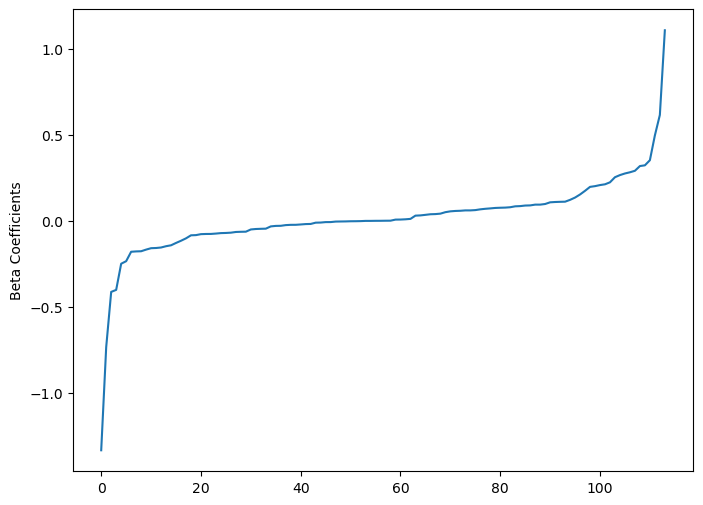

In [12]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression()

lrModel = lr.fit(train)

featureCols = pd.DataFrame(preparedDF.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+
  preparedDF.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")

featureCols = featureCols.set_index('idx')
featureCols.head()

plt.rcParams["figure.figsize"] = (8,6)

beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')

In [28]:
preparedDF.schema["features"].metadata["ml_attr"]["attrs"]

{'numeric': [{'idx': 2, 'name': 'Voters_Age'},
  {'idx': 3, 'name': 'Residence_Families_HHCount'},
  {'idx': 7, 'name': 'Mailing_Families_HHCount'},
  {'idx': 33, 'name': 'Residence_Addresses_Density'},
  {'idx': 56, 'name': 'CommercialData_AreaMedianEducationYears'},
  {'idx': 57, 'name': 'CommercialData_AreaMedianHousingValue'},
  {'idx': 58, 'name': 'CommercialData_AreaPcntHHMarriedCoupleNoChild'},
  {'idx': 59, 'name': 'CommercialData_AreaPcntHHMarriedCoupleWithChild'},
  {'idx': 60, 'name': 'CommercialData_AreaPcntHHSpanishSpeaking'},
  {'idx': 61, 'name': 'CommercialData_AreaPcntHHWithChildren'}],
 'binary': [{'idx': 0, 'name': 'Voters_Gender_F'},
  {'idx': 1, 'name': 'Voters_Gender_M'},
  {'idx': 4, 'name': 'Residence_HHGender_Description_Mixed Gender Household'},
  {'idx': 5, 'name': 'Residence_HHGender_Description_Female Only Household'},
  {'idx': 6, 'name': 'Residence_HHGender_Description_Male Only Household'},
  {'idx': 8, 'name': 'Mailing_HHGender_Description_Mixed Gender 

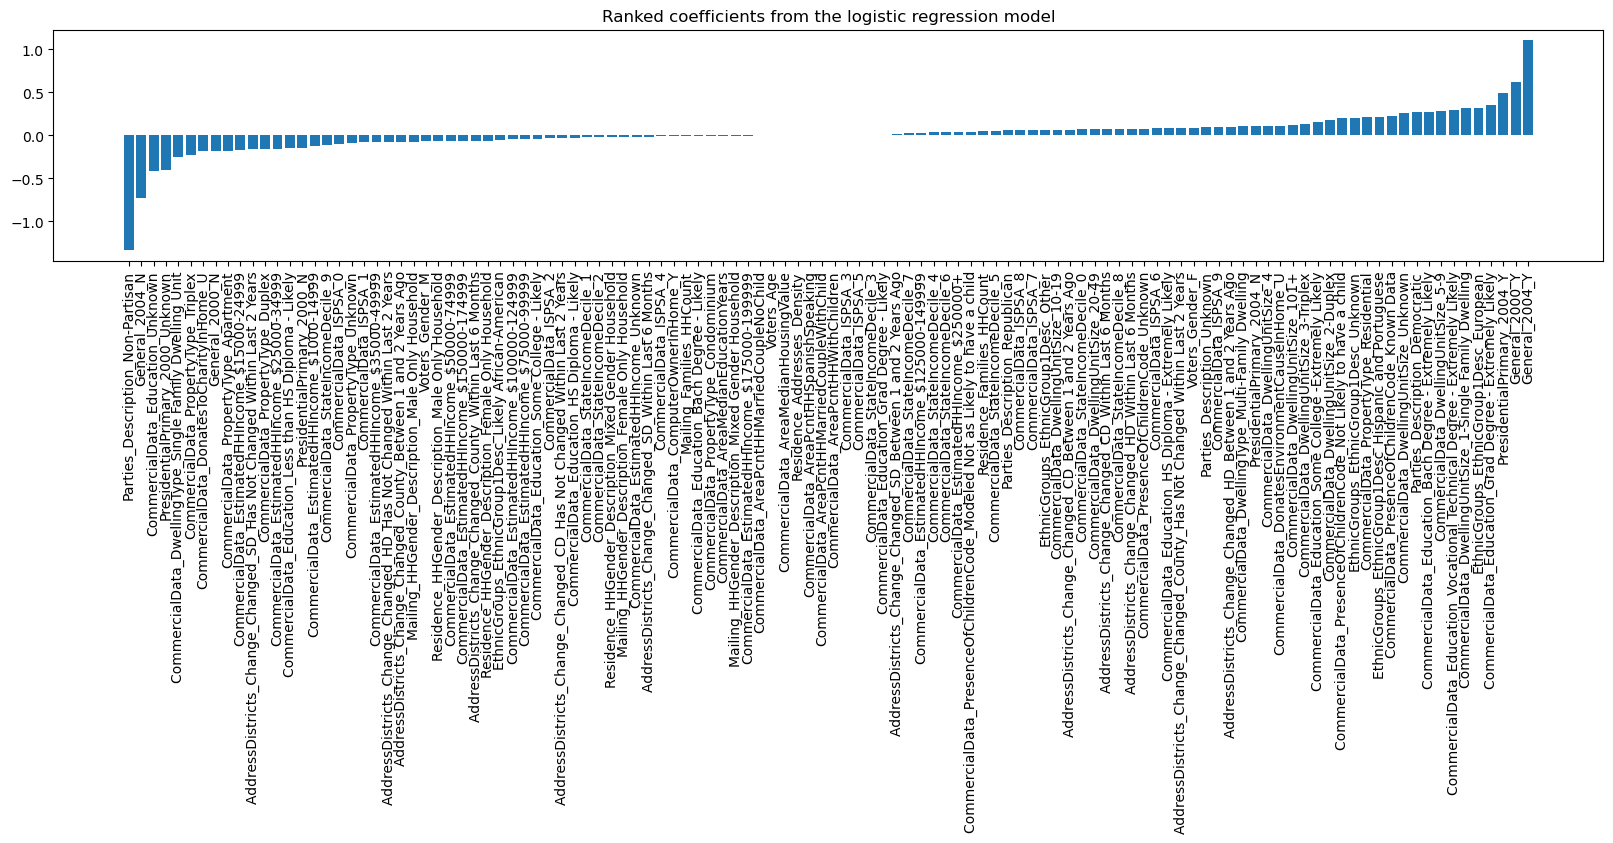

In [13]:
coefsArray = np.array(lrModel.coefficients)  # convert to np.array
coefsDF = pd.DataFrame(coefsArray, columns=['coefs'])  # to pandas

coefsDF = coefsDF.merge(featureCols, left_index=True, right_index=True)  # join it with featureCols we created above
coefsDF.sort_values('coefs', inplace=True)  # Sort them
coefsDF.head()

plt.rcParams["figure.figsize"] = (20,3)

plt.xticks(rotation=90)
plt.bar(coefsDF.name, coefsDF.coefs)
plt.title('Ranked coefficients from the logistic regression model')
plt.show()

# Propensity score estimator

In [ ]:
num_voters_indiana = indi.count()
num_voters_not_indiana = df_ref.count()
pct_sample = num_voters_indiana / num_voters_not_indiana

# empty list to store the estimated average treatment effects:
ATEs = []

# empty dictionary to store output
stored_DF = {}

# start_time = time.time()

for i in range(1):
    i = i + 1 # from 1 - 100 rather than 0 to 100
    
    print(f"iteration {i}")

    # take random sample of the total parquet file (equivalent to the size of indiana)
    df_ref_sampled = df_ref.sample(True, pct_sample, seed = i)

    # create dummy DATA:
#     indi = indi.withColumn('Voters_Age', rand())
#     df_ref = df_ref.withColumn('Voters_Age', rand())
    
#     indi = indi.select(["Voters_Age"])
#     df_ref = df_ref.select(["Voters_Age"])

#     indi = indi.withColumn('Voters_Age', col('Voters_Age').cast('double'))
#     df_ref = df_ref.withColumn('Voters_Age', col('Voters_Age').cast('double'))

#     indi = indi.withColumn('General_2008_RANDOM', when(rand() > 0.5, 1).otherwise(0))
#     df_ref = df_ref.withColumn('General_2008_RANDOM', when(rand() > 0.5, 1).otherwise(0))

    # create a column with "LAW == 0" for non-Indiana states
    df_ref_sampled = df_ref_sampled.withColumn("LAW", lit(0))

    # create a column with "LAW == 1" for Indiana
    indi = indi.withColumn("LAW", lit(1))

    # union the two together
    df = df_ref_sampled.union(indi)

    cols_excluded_from_regression = [
        'Voters_BirthDate', # removed this, but KEPT the YEAR that the voter turned 18.
        'STATE',
        'STATE_ind',
        'DATE_18',
        'comparator_date_presidential',
        'comparator_date_primary',
        'YEAR_ELIGIBLE_TO_VOTE_PRESIDENTIAL',
        'YEAR_ELIGIBLE_TO_VOTE_PRIMARY',
        'Voted_General_2008'
    ]
    
    df_input_logistic = df.drop(*cols_excluded_from_regression)

    # fit logistic model on the intervention (variable Law)
    nrow_df_input_logistic_start_check = df_input_logistic.count()
#     df_input_logistic = df_input_logistic.fillna(0)
    df_input_logistic.columns
    supervised = RFormula(formula="LAW ~ .")
    fittedRF = supervised.fit(df_input_logistic) # inspect column types
    prepareddf_input_logistic = fittedRF.transform(df_input_logistic) # create feature and label columns
    prepareddf_input_logistic.show(5, truncate = False)
    lr = LogisticRegression(labelCol="label",featuresCol="features")
    print(lr.explainParams())
    lrModel = lr.fit(prepareddf_input_logistic) # train model
    lrModel.transform(prepareddf_input_logistic).select("label", "prediction") # fitted values

    # get a propensity score from the probability as a new column:
    fitted = lrModel.transform(prepareddf_input_logistic)
    fitted = fitted.withColumn('probability', vector_to_array('probability'))
    array_mean = udf(lambda x: float(np.mean(x)), FloatType())
    fitted = fitted.withColumn("propensity_score", array_mean("probability"))
    try:
        assert fitted.count() == nrow_df_input_logistic_start_check
    except:
        Exception("before and after don't have same number of columns")

    # new column that called weight that is T - PS / (PS * 1 - PS)
    fitted = fitted.withColumn("weight", (col("label") - col("propensity_score")) / (col("propensity_score") * (1-col("propensity_score"))))

    # merge back in the 2008 general election OUTCOME data
    fitted = fitted.withColumn("row_id", monotonically_increasing_id())
    df = df.withColumn("row_id", monotonically_increasing_id())
    num_row_df_prior = df.count()
    df = df.join(fitted, ["row_id", "Voters_Age", "LAW"]).drop("row_id")
    
    try:
        assert num_row_df_prior == df.count()
    except:
        Exception("before and after don't have same number of columns")

    # calculate the weighted average
    df = df.withColumn("weighted_outcome", col("General_2008_RANDOM") * col("weight"))

    # store weighted average into list
    ATE_this_round = df.agg(avg(col("weighted_outcome"))).collect()[0][0]
    ATEs.append(ATE_this_round)

    # store the DataFrame into a dictionary
    stored_DF[f"{i}"] = df
    
# end_time = time.time()
# print("Execution time: {:.2f} seconds".format(end_time - start_time))

In [ ]:
df.show(10)

In [ ]:
ATEs

In [ ]:
range(1)

In [ ]:
start_time = time.time()
end_time = time.time()
print("Execution time: {:.2f} seconds".format(end_time - start_time))